### Telecom Churn Prediction

# Business Goal

In this project, we will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

# 1. Loading dependencies & datasets

Lets start by loading dependencies. 

In [2]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Loading the datasets and the test data file.

In [3]:
data = pd.read_csv("train (1).csv")
unseen = pd.read_csv("test (1).csv")
sample = pd.read_csv("sample (2).csv")
data_dict = pd.read_csv("data_dictionary (1).csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


In [4]:
#Observe the data 
data.head(5)

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


In [5]:
#Observe more information on data like data types and null values
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

#Add some of the dervied columns like average daily usage and average 3d gain. These columns seem more importnat from business perspective

In [6]:
data['avg_daily_usage']=(data['total_og_mou_6']+data['total_og_mou_7']+data['total_og_mou_8'])/data['aon'].round(0)

In [7]:
data['avg_3g_gain']=(((data['vol_3g_mb_6']-data['vol_3g_mb_7'])-data['vol_3g_mb_8'])/3).round(0)

In [8]:
data['avg_2g_gain']=(((data['vol_2g_mb_6']-data['vol_2g_mb_7'])-data['vol_2g_mb_8'])/3).round(0)

#Consider all total related columns, revenue columns , volume columns. Date columns are not needed as there is no histrical data of users

In [9]:
ids = ['id','circle_id']
total_amounts = [i for i in list(data.columns) if re.search('total.+amt',i)]
total_outgoing_minutes = [i for i in list(data.columns) if re.search('total.+og.+mou',i)]
offnetwork_minutes = [i for i in list(data.columns) if re.search('offnet',i)]
average_revenue_3g = [i for i in list(data.columns) if re.search('arpu.+3g',i)]
average_revenue_2g = [i for i in list(data.columns) if re.search('arpu.+2g',i)]
volume_3g = [i for i in list(data.columns) if re.search('vol.+3g',i)]
volume_2g = [i for i in list(data.columns) if re.search('vol.+2g',i)]
age_on_network = [i for i in list(data.columns) if re.search('aon',i)]
avg_daily_usage=[i for i in list(data.columns) if re.search('avg_daily_usage',i)]
avg_3g_gain=[i for i in list(data.columns) if re.search('avg_3g_gain',i)]
avg_2g_gain=[i for i in list(data.columns) if re.search('avg_2g_gain',i)]

#Storing them in a single flat list
variables = [*ids,             
             *total_amounts, 
             *total_outgoing_minutes, 
             *offnetwork_minutes, 
             *average_revenue_3g, 
             *average_revenue_2g,
             *volume_3g,
             *volume_2g,
             *age_on_network,
             *avg_daily_usage,
             *avg_3g_gain,
             *avg_2g_gain,
             'churn_probability']

data = data[variables].set_index('id')

Let's also summarize the features using the df.describe method:

In [10]:
data.describe(include="all")

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,avg_daily_usage,avg_3g_gain,avg_2g_gain,churn_probability
count,69999.0,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,...,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000
mean,109.0,328.139788,322.376363,323.846355,306.451436,310.572674,304.513065,198.874771,197.153383,196.543577,...,128.934444,135.486541,51.773924,51.240204,50.127506,1220.639709,1.446863,-47.417106,-16.529722,0.101887
std,0.0,404.211068,411.070120,426.181405,465.502866,479.131770,477.936832,316.818355,322.482226,324.089234,...,554.096072,568.310234,212.513909,211.114667,213.101403,952.426321,2.855884,252.718832,100.487774,0.302502
min,109.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,-13427.000000,-5407.000000,0.000000
25%,109.0,110.000000,100.000000,90.000000,44.780000,42.910000,38.710000,34.860000,32.240000,31.575000,...,0.000000,0.000000,0.000000,0.000000,0.000000,468.000000,0.173900,0.000000,0.000000,0.000000
50%,109.0,229.000000,220.000000,225.000000,145.280000,141.230000,138.360000,96.480000,91.885000,91.800000,...,0.000000,0.000000,0.000000,0.000000,0.000000,868.000000,0.491472,0.000000,0.000000,0.000000
75%,109.0,438.000000,430.000000,436.000000,374.305000,380.045000,370.895000,232.990000,227.630000,229.345000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1813.000000,1.477867,0.000000,0.000000,0.000000
max,109.0,35190.000000,40335.000000,45320.000000,10674.030000,8285.640000,14043.060000,8362.360000,7043.980000,14007.340000,...,28144.120000,30036.060000,10285.900000,7873.550000,11117.610000,4337.000000,76.822110,8517.000000,1388.000000,1.000000


# 2. Create X, y and then Train test split

Lets create X and y datasets and skip "circle_id" since it has only 1 unique value

In [11]:
data['circle_id'].unique()

array([109])

In [12]:
X = data.drop(['circle_id'],1).iloc[:,:-1]
y = data.iloc[:,-1]

X.shape, y.shape

((69999, 25), (69999,))

Splitting train and test data to avoid any contamination of the test data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55999, 25), (14000, 25), (55999,), (14000,))

In [14]:
X_train.head()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,arpu_3g_6,...,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,avg_daily_usage,avg_3g_gain,avg_2g_gain
id,,,,,,,,,,,,,,,,,,,,,
22402,240,290,144,196.88,302.11,237.79,173.83,269.74,218.98,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,2485,0.296491,0.0,0.0
13753,505,404,585,491.24,619.76,557.33,393.29,517.13,420.23,172.89,...,63.69,58.69,120.01,2.24,2.41,25.52,354,4.712797,-38.0,-9.0
12287,754,798,544,412.26,223.09,348.59,400.19,206.88,329.26,0.00,...,0.00,0.00,0.00,1012.66,1084.82,730.71,507,1.940710,0.0,-268.0
18574,582,808,708,247.18,416.88,638.31,215.98,287.39,479.64,96.22,...,1816.40,731.25,638.92,146.37,30.45,61.17,3141,0.414635,149.0,18.0
41490,140,115,130,110.61,138.46,86.18,79.96,108.59,57.38,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,2113,0.158661,0.0,0.0


# 3. Handling Missing data

Lets analyse the missing data. We can use missingno library for visualizations.

<AxesSubplot:>

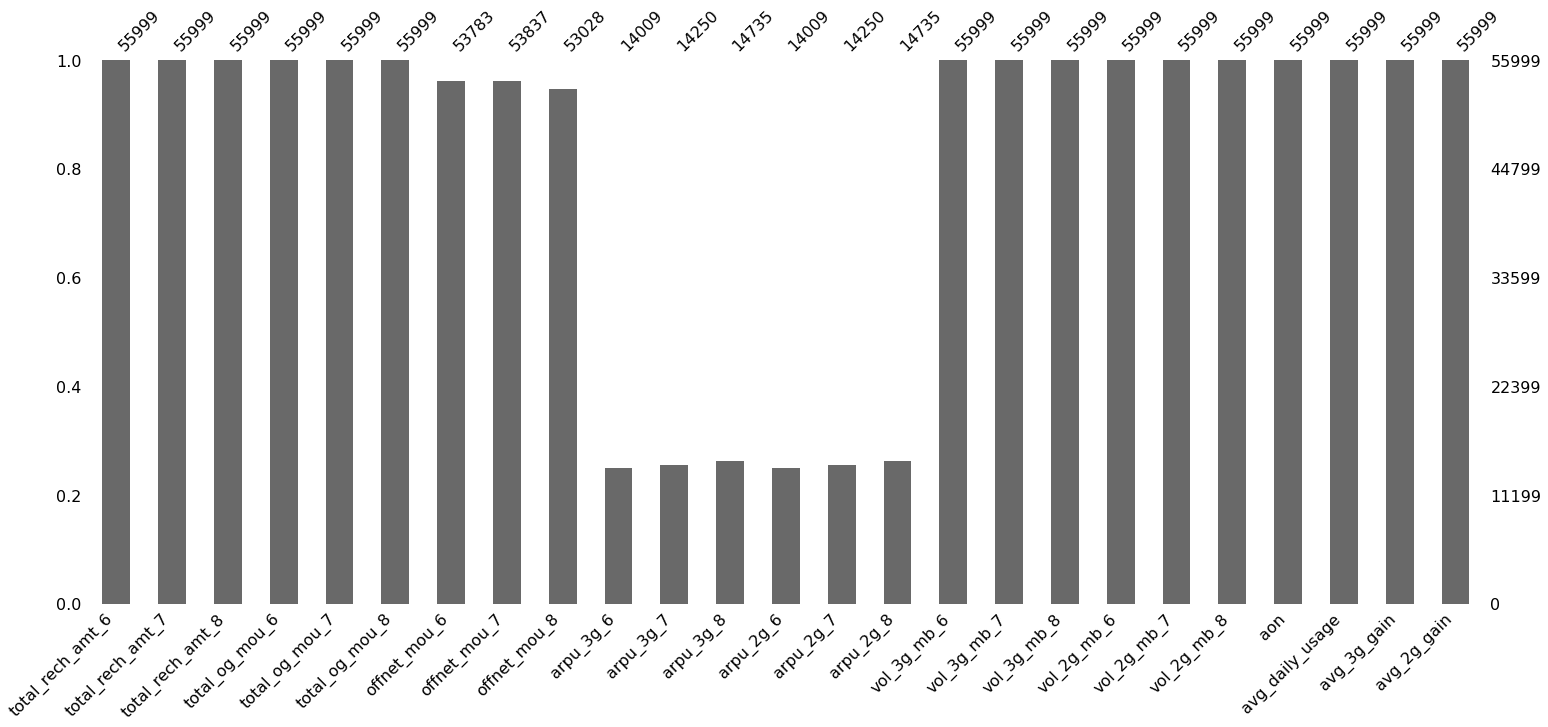

In [15]:
msno.bar(X_train)

<AxesSubplot:>

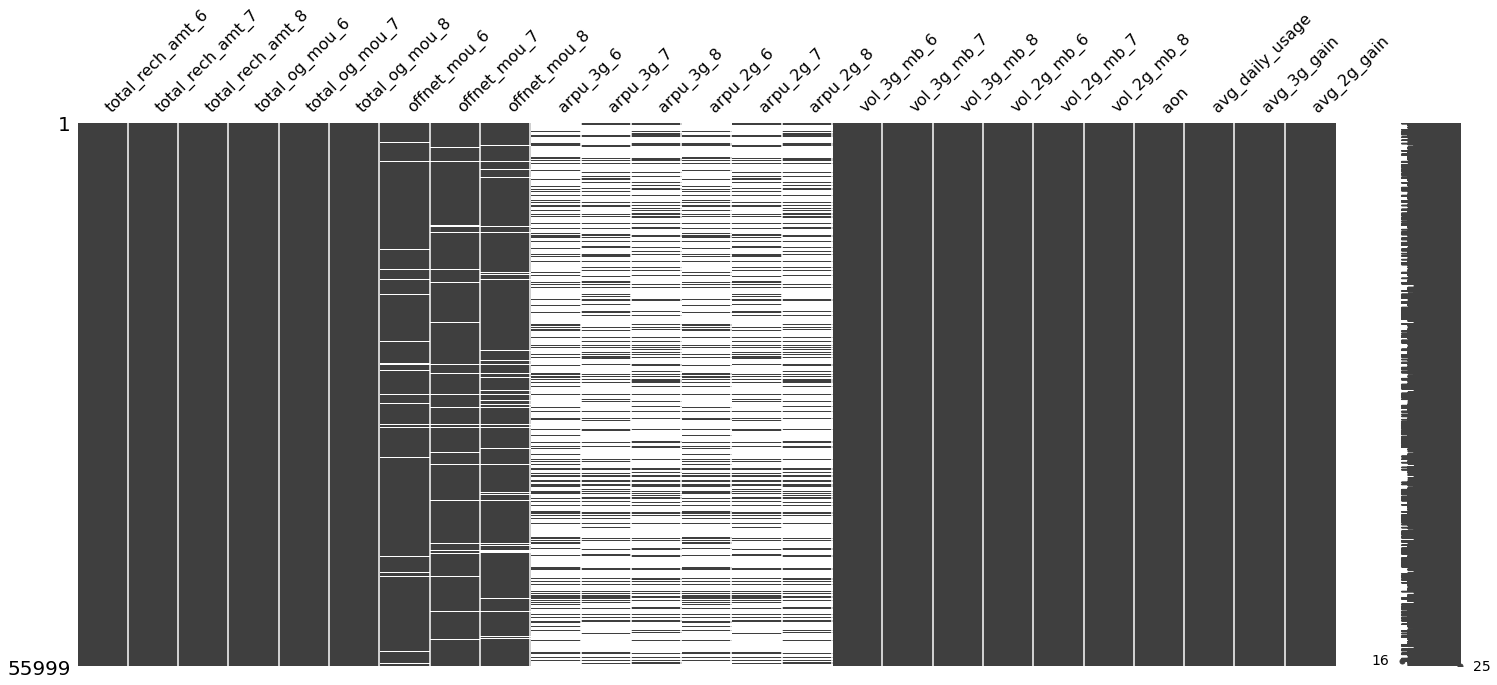

In [16]:
msno.matrix(X_train)

Lets also calculate the % missing data for each column:

In [17]:
missing_data_percent = 100*X_train.isnull().sum()/len(y_train)
missing_data_percent

total_rech_amt_6     0.000000
total_rech_amt_7     0.000000
total_rech_amt_8     0.000000
total_og_mou_6       0.000000
total_og_mou_7       0.000000
total_og_mou_8       0.000000
offnet_mou_6         3.957214
offnet_mou_7         3.860783
offnet_mou_8         5.305452
arpu_3g_6           74.983482
arpu_3g_7           74.553117
arpu_3g_8           73.687030
arpu_2g_6           74.983482
arpu_2g_7           74.553117
arpu_2g_8           73.687030
vol_3g_mb_6          0.000000
vol_3g_mb_7          0.000000
vol_3g_mb_8          0.000000
vol_2g_mb_6          0.000000
vol_2g_mb_7          0.000000
vol_2g_mb_8          0.000000
aon                  0.000000
avg_daily_usage      0.000000
avg_3g_gain          0.000000
avg_2g_gain          0.000000
dtype: float64

Since too much missing information would make a column not really a great predictor for churn, we drop these columns and keep only the ones which have less than 40% missing data.

In [18]:
new_vars = missing_data_percent[missing_data_percent.le(40)].index
new_vars

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon',
       'avg_daily_usage', 'avg_3g_gain', 'avg_2g_gain'],
      dtype='object')

In [19]:
X_train_filtered = X_train[new_vars]
X_train_filtered.shape

(55999, 19)

In [20]:
missing_data_percent = X_train_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8'], dtype='object')

In [21]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_train_filtered[impute_cols] = imp.fit_transform(X_train_filtered[impute_cols])

<AxesSubplot:>

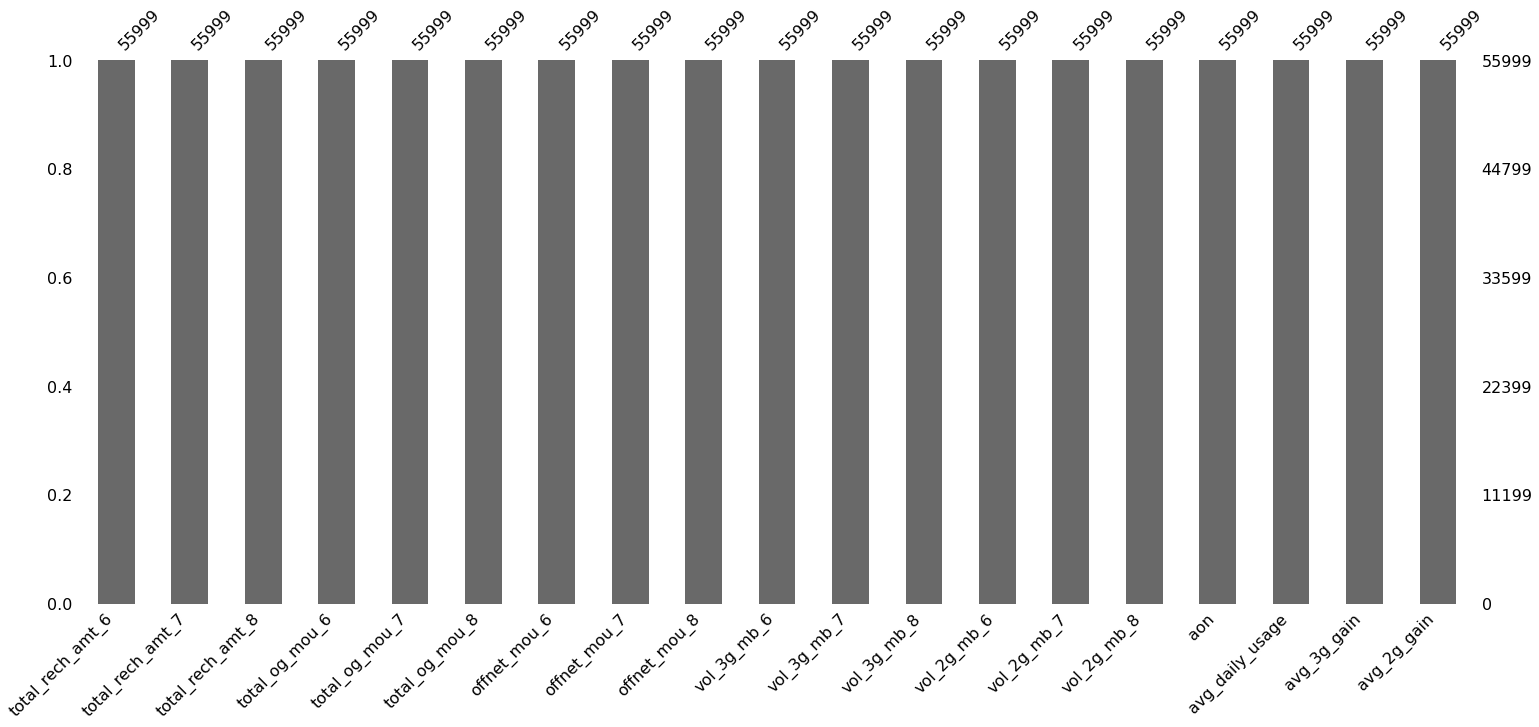

In [22]:
msno.bar(X_train_filtered)

In [23]:
X_train_filtered.describe()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,avg_daily_usage,avg_3g_gain,avg_2g_gain
count,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000
mean,329.012929,322.371614,323.916784,308.034530,311.805332,304.959193,191.881132,189.920947,186.454781,121.645621,127.456776,135.106971,51.384199,50.885135,50.141612,1217.978214,1.453279,-46.973767,-16.546135
std,409.010942,411.560016,432.848241,466.570379,481.868400,478.283771,314.466528,320.086467,319.466183,567.434538,546.986065,576.763045,212.876459,209.669847,214.689115,952.093574,2.866049,251.786605,100.862318
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,-13427.000000,-5407.000000
25%,110.000000,100.000000,90.000000,44.860000,42.640000,38.430000,28.760000,26.490000,23.440000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,467.000000,0.175213,0.000000,0.000000
50%,230.000000,220.000000,225.000000,146.130000,142.260000,138.490000,90.230000,85.830000,83.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,866.000000,0.494032,0.000000,0.000000
75%,440.000000,430.000000,437.000000,377.570000,382.395000,371.870000,224.560000,218.950000,216.760000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1806.000000,1.483661,0.000000,0.000000
max,35190.000000,40335.000000,45320.000000,8488.360000,8285.640000,14043.060000,8362.360000,7043.980000,14007.340000,45735.400000,27600.290000,30036.060000,10285.900000,7873.550000,11117.610000,4321.000000,76.822110,8517.000000,1388.000000


# 4. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

<AxesSubplot:>

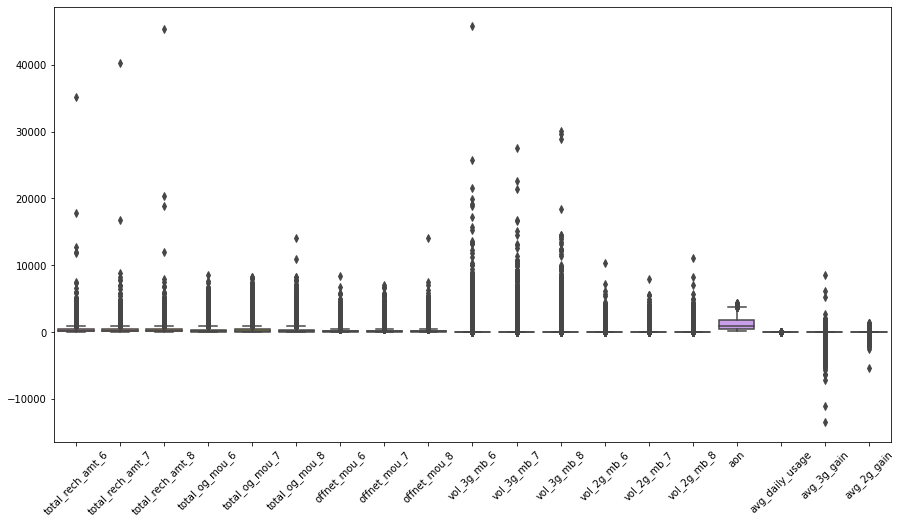

In [24]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered)

We can see that there are lot of outliers. We need to hanlde outliers

### 4.1 Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [25]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

<AxesSubplot:>

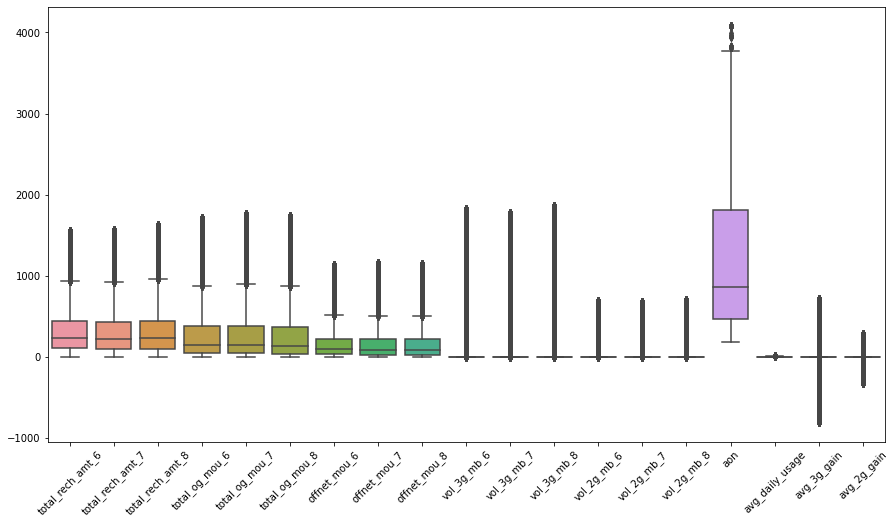

In [26]:
X_train_filtered1 = X_train_filtered.apply(cap_outliers, axis=0)

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered1)

### 4.2 Feature scaling

Lets also scale the features by scaling them with Standard scaler 

In [27]:
scale = StandardScaler()
X_train_filtered2 = scale.fit_transform(X_train_filtered1)

<AxesSubplot:>

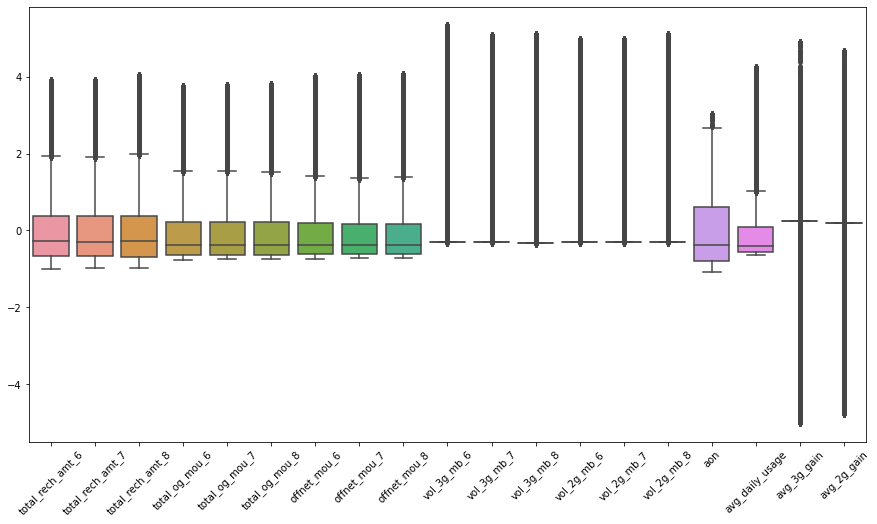

In [28]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_filtered2, columns=new_vars))

Lets plot heatmap to find co-relation between variables  

<AxesSubplot:>

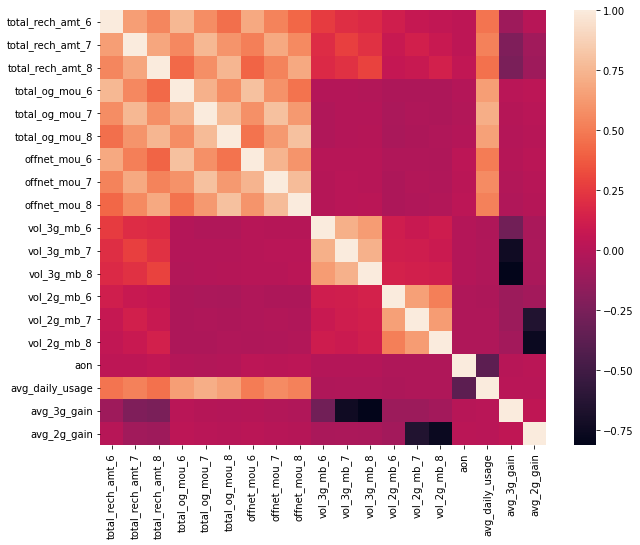

In [29]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(X_train_filtered2, columns=new_vars).corr())

Not much of correlatio seen Hence no need to drop any columns

<AxesSubplot:xlabel='churn_probability', ylabel='Count'>

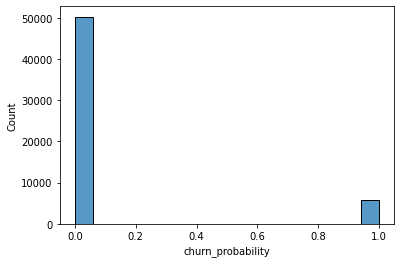

In [30]:
#Distribution for the churn probability
sns.histplot(y_train)

# Handling Class Imbalance problem

In [31]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_sm,y_train_sm = sm.fit_resample(X_train_filtered2,y_train)


# 5. Feature engineering and selection

Let's understand feature importances for raw features as well as components to decide top features for modelling.

In [32]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train_filtered2, y_train)

RandomForestClassifier(n_jobs=-1)

In [33]:
feature_importances = pd.DataFrame({'col':new_vars, 'importance':rf.feature_importances_})

<BarContainer object of 19 artists>

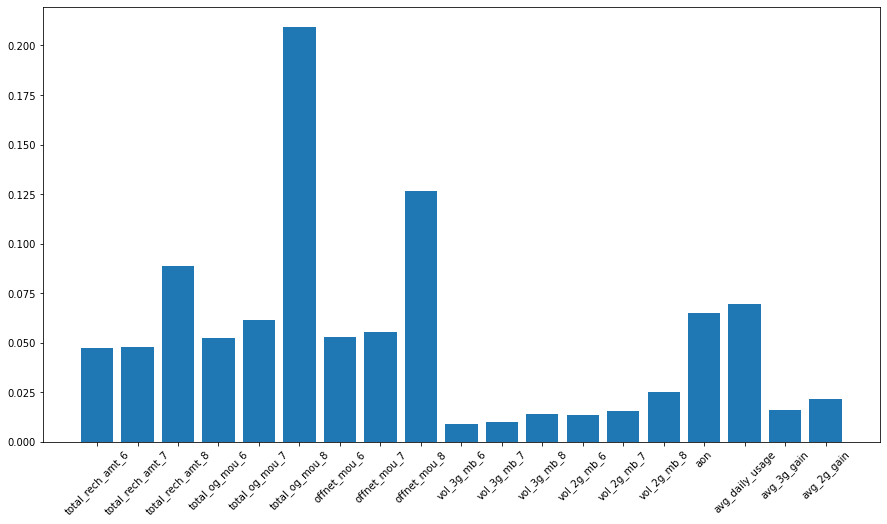

In [34]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

# 6. Model building

#Build Logistic Regression Model

In [35]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=10)
lr = LogisticRegression(max_iter=1000, tol=0.001)

In [36]:
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',lr)])

In [37]:
pipe.fit(X_train[new_vars], y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=10)),
                ('model', LogisticRegression(max_iter=1000, tol=0.001))])

In [38]:
train_score = pipe.score(X_train[new_vars], y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.8994624904016143


In [39]:
test_score = pipe.score(X_test[new_vars], y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.9023571428571429


In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pipe.predict(X_test[new_vars])))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     12619
           1       0.55      0.06      0.10      1381

    accuracy                           0.90     14000
   macro avg       0.73      0.53      0.53     14000
weighted avg       0.87      0.90      0.87     14000



Results: We can see F1-Score is very low as recall is very low. For this problem recall i.e. sensitity is very improtant.
Hence this model is not sutiable for this problem

# Build the lightgbm model

In [41]:
import lightgbm as lgb
clf = lgb.LGBMClassifier(boosting_type='dart', objective='binary', num_leaves=60,
                                learning_rate=0.007, n_estimators=6000, max_depth=30,
                                 random_state=1121218,
   
                                )


In [42]:
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('model',clf)])

In [43]:
pipe.fit(X_train[new_vars], y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()),
                ('model',
                 LGBMClassifier(boosting_type='dart', learning_rate=0.007,
                                max_depth=30, n_estimators=6000, num_leaves=60,
                                objective='binary', random_state=1121218))])

In [44]:
train_score = pipe.score(X_train[new_vars], y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.9507134055965285


In [45]:
test_score = pipe.score(X_test[new_vars], y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.9372142857142857


Let's make a confusion matrix to analyze how each class is being predicted by the model.

In [46]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pipe.predict(X_test[new_vars])))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     12619
           1       0.72      0.60      0.65      1381

    accuracy                           0.94     14000
   macro avg       0.84      0.79      0.81     14000
weighted avg       0.93      0.94      0.93     14000



In [141]:
confusion_matrix(y_train, pipe.predict(X_train[new_vars]))

array([[49370,   910],
       [ 1838,  3881]])

In [142]:
confusion_matrix(y_test, pipe.predict(X_test[new_vars]))

array([[12264,   323],
       [  610,   803]])

We can see a high amount of type 2 error. Due to class imbalance, the model is clearly trying to predict majority of the cases as class 0. Understanding how to handle class imbalance in classification models might be the key to winning this competition :) (hint!)

In [143]:
precision_score(y_test, pipe.predict(X_test[new_vars]))

0.7131438721136767

In [144]:
recall_score(y_test, pipe.predict(X_test[new_vars]))

0.5682944090587403

Results - F1 Score is good Hence this model can be used 

# 7. Creating submission file

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [52]:
sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


In [53]:
unseen.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


Lets first select the columns that we want to work with (or create them, if you have done any feature engineering)

In [54]:
unseen['avg_daily_usage']=(unseen['total_og_mou_6']+unseen['total_og_mou_7']+unseen['total_og_mou_8'])/unseen['aon'].round(0)

In [55]:
unseen['avg_3g_gain']=data['avg_3g_gain']=(((unseen['vol_3g_mb_6']-unseen['vol_3g_mb_7'])-unseen['vol_3g_mb_8'])/3).round(0)

In [56]:
submission_data = unseen.set_index('id')[new_vars]
submission_data.shape

(30000, 18)

Next, lets create a new column in the unseen dataset called churn_probability and use the model pipeline to predict the probabilities for this data

In [57]:
unseen['churn_probability'] = pipe.predict(submission_data)
output = unseen[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,1
3,70002,0
4,70003,0


Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.

In [58]:
output.to_csv('Telco_churn_dataset',index=False)

Recommend strategies to manage customer churn:As we can see from Random Forest feature importance, the features which are important for churn are total outgoing calls, total recharge , average daily usage per user, Age on netwrok. 
To keep the cutomers churn rate low, some of the strategies that can be applied as below 
1. Number outgoing calls can be increased like free outgoing calls between few hours in a day or some days in a month 
2. Total recharge can be incresed by giving some discounts or differnt promo offers.
3. Average daily usage per user can be increased by daily discounts. 
4. Age on newtwork can be incresed by good/stable services, dicount offers, csutomer interaction etc.